In [24]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import lmfit

from General.plotting import plot
from General.plotting import cbar
import General.numpy_funcs as npf

In [25]:
loc = r'E:\OneDrive - TU Eindhoven\Master thesis\Measurements\lamp_test.hdf5'
timestamp = []
intensity = []
with h5py.File(loc) as file:
    group = file['2023-11-08_lamp_stability']['uv-vis']
    wavelength = group.attrs['wavelength']
    background = group.attrs['background']
    for key in group.keys():
        timestamp.append(group[key].attrs['time_ms'])
        intensity.append(group[key][()]) 

intensity = np.array(intensity)
timestamp = np.array(timestamp)

In [26]:
arg_sort = np.argsort(timestamp)
intensity_sorted = intensity[arg_sort]
timestamp_sorted = timestamp[arg_sort]

mask = (wavelength > 200) & (wavelength < 400)
wav_mask = wavelength[mask]
inten_mask = intensity_sorted[:, mask]

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float, axis=0)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

n_average = 25
averaged_timestamps = moving_average(timestamp_sorted-timestamp_sorted[0], n_average)/60_000
averaged_intensity = moving_average(inten_mask, n_average)
averaged_intensity = averaged_intensity/averaged_intensity[-1]

C:\Users\20222772\PycharmProjects\MasterDataAnalysis\General\plotting\plot.py:359: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\20222772\PycharmProjects\MasterDataAnalysis\General\plotting\plot.py:359: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


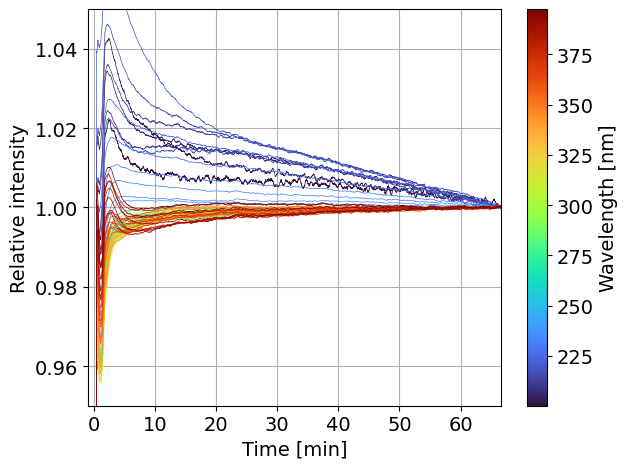

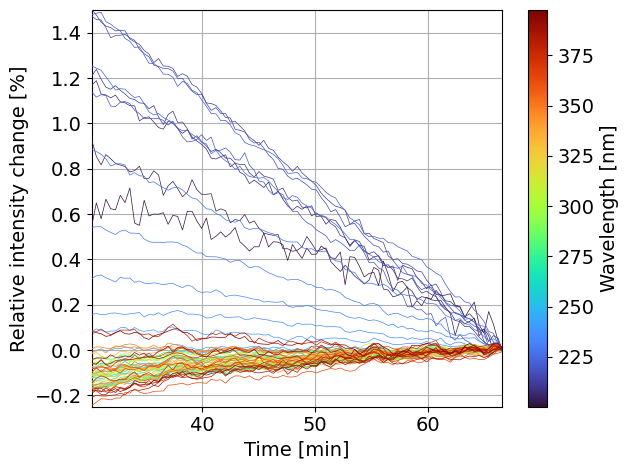

In [45]:
jet = plt.get_cmap('jet')
every = 10
save_loc = r'E:\OneDrive - TU Eindhoven\Master thesis\Tex\Images\Measurement techniques\intensity_stability'

wavs = wav_mask[::every]
intens = averaged_intensity.T[::every]
colors, sm = cbar.cbar_norm_colors(wavs)
plot_kwargs = {'xlabel': 'Time [min]', 'ylabel': 'Relative intensity', 'ylim': (0.95, 1.05), 'xlim': (-1, averaged_timestamps[-1])}
cbar_kwargs = {'label': 'Wavelength [nm]', 'mappable': sm}
line_kwargs = {'linewidth': 0.5}
plot.lines(averaged_timestamps, intens, colors=colors, plot_kwargs=plot_kwargs, cbar_kwargs=cbar_kwargs, line_kwargs=line_kwargs, save_loc=f'{save_loc}_all.pdf')

index = np.searchsorted(averaged_timestamps, 30)

num = 25
intens_avg = np.array([npf.block_average(x[index:], 25) for x in intens])
time_avg = npf.block_average(averaged_timestamps[index:], 25)
plot_kwargs = {'xlabel': 'Time [min]', 'ylabel': 'Relative intensity change [%]', 'ylim': (-0.25, 1.5)}
plot.lines(time_avg, 100*(intens_avg-1), colors=colors, plot_kwargs=plot_kwargs, cbar_kwargs=cbar_kwargs, line_kwargs=line_kwargs, save_loc=f'{save_loc}_change.pdf')

In [5]:
index = np.searchsorted(averaged_timestamps, 50)
intensity_selected = intensity_sorted[index:]
lin_model = lmfit.models.LinearModel()

slopes = []
slopes_std = []

for wav in intensity_selected.T:
    result = lin_model.fit(wav, x=np.arange(len(wav)))
    slopes.append(result.params['slope'].value)
    slopes_std.append(result.params['slope'].stderr)

slopes = np.array(slopes)
slopes_std = np.array(slopes_std)

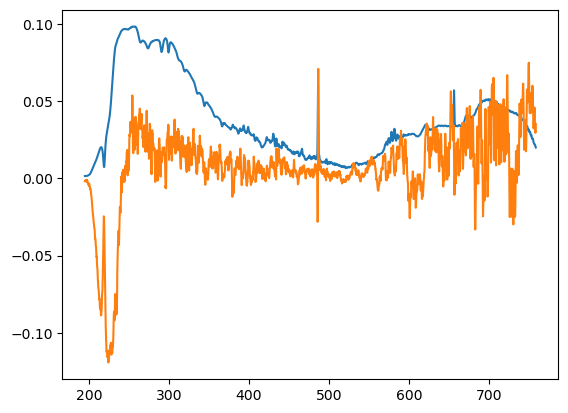

In [6]:
every = 1
plt.figure()
plt.plot(wavelength, intensity_sorted[-1]/600_000)
plt.plot(wavelength[::every], slopes[::every], '-')
plt.show()